# Train a model on the deep-snow dataset

In [2]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import pickle
import random

import deep_snow.models
import deep_snow.dataset

## Prepare dataloader

In [2]:
# get paths to data
train_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/train'
train_path_list = glob(f'{train_data_dir}/ASO_50M_SD*.nc')

val_data_dir = '/mnt/Backups/gbrench/repos/deep-snow/data/subsets_v4/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# # to test code with a small sample of the data
# import random
# n_imgs = 16

# train_path_list = random.sample(train_path_list, n_imgs )
# val_path_list = random.sample(val_path_list, n_imgs)

In [3]:
# define data to be returned by dataloader
selected_channels = [
    # ASO products
    'aso_sd', # ASO lidar snow depth (target dataset)
    'aso_gap_map', # gaps in ASO data
    
    # Sentinel-1 products
    'snowon_vv', # snow on Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vh', # snow on Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter in dB, closest acquisition to ASO acquisition
    'snowon_vv_mean', # snow on Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_vh_mean', # snow on Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vv_mean', # snow off Sentinel-1 VV polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowoff_vh_mean', # snow off Sentinel-1 VH polarization backscatter in dB, mean of acquisition in 4 week period around ASO acquisition
    'snowon_cr', # cross ratio, snowon_vh - snowon_vv
    'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
    'delta_cr', # change in cross ratio, snowon_cr - snowoff_cr
    'rtc_gap_map', # gaps in Sentinel-1 data
    'rtc_mean_gap_map', # gaps in Sentinel-1 mean data
    
    # Sentinel-2 products 
    'aerosol_optical_thickness', # snow on Sentinel-2 aerosol optical thickness band 
    'coastal_aerosol', # snow on Sentinel-2 coastal aerosol band
    'blue', # snow on Sentinel-2 blue band
    'green', # snow on Sentinel-2 green band
    'red', # snow on Sentinel-2 red band
    'red_edge1', # snow on Sentinel-2 red edge 1 band
    'red_edge2', # snow on Sentinel-2 red edge 2 band
    'red_edge3', # snow on Sentinel-2 red edge 3 band
    'nir', # snow on Sentinel-2 near infrared band
    'water_vapor', # snow on Sentinel-2 water vapor
    'swir1', # snow on Sentinel-2 shortwave infrared band 1
    'swir2', # snow on Sentinel-2 shortwave infrared band 2
    'scene_class_map', # snow on Sentinel-2 scene classification product
    'water_vapor_product', # snow on Sentinel-2 water vapor product
    'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
    'ndsi', # Normalized Difference Snow Index from Sentinel-2
    'ndwi', # Normalized Difference Water Index from Sentinel-2
    's2_gap_map', # gaps in Sentinel-2 data

    # snodas datset
    'snodas_sd', # snow depth

    # PROBA-V global land cover dataset (Buchhorn et al., 2020)
    'fcf', # fractional forest cover
    
    # COP30 digital elevation model      
    'elevation',
    'slope',
    'aspect',
    'northness',
    'eastness',
    'curvature',
    'tpi',
    'tri',

    # latitude and longitude
    'latitude',
    'longitude',

    # day of water year
    'dowy'
                    ]

# prepare training and validation dataloaders
train_data = deep_snow.dataset.Datasetv2(train_path_list, selected_channels, norm=True, cache_data=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_data = deep_snow.dataset.Datasetv2(val_path_list, selected_channels, norm=True, augment=False, cache_data=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=16, shuffle=True)

In [4]:
# define input channels for model
input_channels = ['snodas_sd',
                  'blue',
                  'swir1',
                  'ndsi',
                  'elevation',
                  'northness',
                  'slope',
                  'curvature',
                  'dowy',
                  'delta_cr',
                  'fcf'
                 ]


## Train model

In [5]:
# import model
# model = deep_snow.models.SimpleCNN(n_input_channels=len(input_channels))
# model = deep_snow.models.UNet(n_input_channels=len(input_channels))
# model = deep_snow.models.ResUNet(n_input_channels=len(input_channels))
# model = deep_snow.models.ResDepth(n_input_channels=len(input_channels))
# model = deep_snow.models.VisionTransformer(n_input_channels=len(input_channels))

model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.to('cuda');  # Run on GPU

# name your model
model_name = 'quinn_ResDepth_v12'

In [ ]:
# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss_fn = nn.MSELoss()
epochs = 500
min_val_loss = 1

train_loss = []
val_loss = []

# training and validation loop
for epoch in range(epochs):
    print(f'\nStarting epoch {epoch+1}')
    train_epoch_loss = []
    val_epoch_loss = []

    # Loop through training data with tqdm progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in train_pbar:
        model.train()
        optimizer.zero_grad()

        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        
        # prepare inputs by concatenating along channel dimension
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')

        # generate prediction
        pred_sd = model(inputs)

        # Limit prediction to areas with valid data
        pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
        aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda')== 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))

        # Calculate loss
        train_batch_loss = loss_fn(pred_sd, aso_sd.to('cuda'))
        train_epoch_loss.append(train_batch_loss.item())

        # Update tqdm progress bar with batch loss
        train_pbar.set_postfix({'batch loss': train_batch_loss.item(), 'mean epoch loss': np.mean(train_epoch_loss)})

        train_batch_loss.backward()  # Propagate the gradients in backward pass
        optimizer.step()

    train_loss.append(np.mean(train_epoch_loss))
    print(f'Training loss: {np.mean(train_epoch_loss)}')
    scheduler.step(np.mean(train_epoch_loss))

    # Run model on validation data with tqdm progress bar
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch", ncols=130)
    for data_tuple in val_pbar:
        with torch.no_grad():
            model.eval()
            
            # read data into dictionary
            data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
            # prepare inputs by concatenating along channel dimension
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
    
            # generate prediction
            pred_sd = model(inputs)
    
            # Limit prediction to areas with valid data
            pred_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, pred_sd, torch.zeros_like(pred_sd).to('cuda'))
            aso_sd = torch.where(data_dict['aso_gap_map'].to('cuda') + data_dict['rtc_gap_map'].to('cuda') + data_dict['s2_gap_map'].to('cuda') == 0, data_dict['aso_sd'].to('cuda'), torch.zeros_like(pred_sd).to('cuda'))
    
            # Calculate loss
            val_batch_loss = loss_fn(pred_sd, aso_sd.to('cuda'))
            val_epoch_loss.append(val_batch_loss.item())

            # Update tqdm progress bar with batch loss
            val_pbar.set_postfix({'batch loss': val_batch_loss.item(), 'mean epoch loss': np.mean(val_epoch_loss)})

    if np.mean(val_epoch_loss) < min_val_loss:
        if epoch > 30:
            min_val_loss = np.mean(val_epoch_loss)
            torch.save(model.state_dict(), f'../../../weights/{model_name}_{epoch}epochs')
                    
    # # calculate loss over previous 10 epochs for early stopping later
    # if epoch > 20:
    #     past_loss = np.mean(val_loss[-20:-10])

    val_loss.append(np.mean(val_epoch_loss))
    print(f'Validation loss: {np.mean(val_epoch_loss)}')
    
    # save loss 
    with open(f'../../../loss/{model_name}_val_loss.pkl', 'wb') as f:
        pickle.dump(val_loss, f)
        
    with open(f'../../../loss/{model_name}_train_loss.pkl', 'wb') as f:
        pickle.dump(train_loss, f)

    # # implement early stopping
    # if epoch > 20:
    #     current_loss = np.mean(val_loss[-10:-1])
    #     if current_loss > past_loss:
    #         counter +=1
    #         if counter >= 10:
    #             print('early stopping triggered')
    #             # save model
    #             torch.save(model.state_dict(), f'../../weights/{model_name}_{epoch}epochs')
    #             break
    #     else:
    #         counter = 0


Starting epoch 1


Epoch 1/500: 100%|████████████████████████████| 774/774 [1:15:10<00:00,  5.83s/batch, batch loss=0.00149, mean epoch loss=0.00209]


Training loss: 0.002090832681556952


Epoch 1/500: 100%|██████████████████████████████| 135/135 [13:59<00:00,  6.22s/batch, batch loss=0.00096, mean epoch loss=0.00111]


Validation loss: 0.0011143556178366352

Starting epoch 2


Epoch 2/500: 100%|██████████████████████████████| 774/774 [03:45<00:00,  3.43batch/s, batch loss=0.00186, mean epoch loss=0.00162]


Training loss: 0.0016206991382928997


Epoch 2/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.15batch/s, batch loss=0.000918, mean epoch loss=0.00099]


Validation loss: 0.000990492763553953

Starting epoch 3


Epoch 3/500: 100%|███████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.00188, mean epoch loss=0.0015]


Training loss: 0.001497325112318827


Epoch 3/500: 100%|██████████████████████████████| 135/135 [00:03<00:00, 35.34batch/s, batch loss=0.00187, mean epoch loss=0.00108]


Validation loss: 0.0010821674519252997

Starting epoch 4


Epoch 4/500: 100%|█████████████████████████████| 774/774 [02:34<00:00,  5.00batch/s, batch loss=0.000805, mean epoch loss=0.00144]


Training loss: 0.0014385271771985121


Epoch 4/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.02batch/s, batch loss=0.00121, mean epoch loss=0.000972]


Validation loss: 0.0009715464278727908

Starting epoch 5


Epoch 5/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000555, mean epoch loss=0.00138]


Training loss: 0.0013796308598036965


Epoch 5/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.82batch/s, batch loss=0.000791, mean epoch loss=0.000883]


Validation loss: 0.000882713789555796

Starting epoch 6


Epoch 6/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000556, mean epoch loss=0.00136]


Training loss: 0.0013623504747305119


Epoch 6/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.99batch/s, batch loss=0.000449, mean epoch loss=0.000908]


Validation loss: 0.0009078122482471237

Starting epoch 7


Epoch 7/500: 100%|██████████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=0.00126, mean epoch loss=0.00131]


Training loss: 0.0013089774533545536


Epoch 7/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.17batch/s, batch loss=0.00166, mean epoch loss=0.000876]


Validation loss: 0.0008755857473092706

Starting epoch 8


Epoch 8/500: 100%|██████████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.00406, mean epoch loss=0.00128]


Training loss: 0.0012791339141898488


Epoch 8/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.04batch/s, batch loss=0.000739, mean epoch loss=0.000836]


Validation loss: 0.0008362248680054175

Starting epoch 9


Epoch 9/500: 100%|█████████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=0.000681, mean epoch loss=0.00126]


Training loss: 0.0012629154230560777


Epoch 9/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.20batch/s, batch loss=0.00129, mean epoch loss=0.000874]


Validation loss: 0.0008743035942272939

Starting epoch 10


Epoch 10/500: 100%|█████████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=0.00127, mean epoch loss=0.00124]


Training loss: 0.0012406053728314516


Epoch 10/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.05batch/s, batch loss=0.000784, mean epoch loss=0.0008]


Validation loss: 0.0008004235705205549

Starting epoch 11


Epoch 11/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000767, mean epoch loss=0.00121]


Training loss: 0.0012124072852956903


Epoch 11/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.40batch/s, batch loss=0.00152, mean epoch loss=0.000827]


Validation loss: 0.0008269262782522235

Starting epoch 12


Epoch 12/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00195, mean epoch loss=0.00122]


Training loss: 0.0012155229191997679


Epoch 12/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.47batch/s, batch loss=0.0014, mean epoch loss=0.000833]


Validation loss: 0.0008330824822661709

Starting epoch 13


Epoch 13/500: 100%|█████████████████████████████| 774/774 [02:31<00:00,  5.11batch/s, batch loss=0.00127, mean epoch loss=0.00119]


Training loss: 0.0011900131394307536


Epoch 13/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.33batch/s, batch loss=0.00108, mean epoch loss=0.000924]


Validation loss: 0.0009241161074627328

Starting epoch 14


Epoch 14/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00268, mean epoch loss=0.00119]


Training loss: 0.0011908872311088637


Epoch 14/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.55batch/s, batch loss=0.000569, mean epoch loss=0.000747]


Validation loss: 0.0007470923558382007

Starting epoch 15


Epoch 15/500: 100%|█████████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=0.00263, mean epoch loss=0.00117]


Training loss: 0.0011669217252177945


Epoch 15/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.38batch/s, batch loss=0.00101, mean epoch loss=0.000796]


Validation loss: 0.0007961480143152315

Starting epoch 16


Epoch 16/500: 100%|█████████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.00153, mean epoch loss=0.00115]


Training loss: 0.0011543936268498672


Epoch 16/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.97batch/s, batch loss=0.00028, mean epoch loss=0.000766]


Validation loss: 0.0007664418637028171

Starting epoch 17


Epoch 17/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.000518, mean epoch loss=0.00115]


Training loss: 0.0011461534806811017


Epoch 17/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.94batch/s, batch loss=0.000312, mean epoch loss=0.000865]


Validation loss: 0.0008651183092432028

Starting epoch 18


Epoch 18/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.000995, mean epoch loss=0.00113]


Training loss: 0.0011290911668963466


Epoch 18/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.46batch/s, batch loss=0.00226, mean epoch loss=0.00107]


Validation loss: 0.00106964035722841

Starting epoch 19


Epoch 19/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.000926, mean epoch loss=0.00112]


Training loss: 0.001121590317657713


Epoch 19/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.94batch/s, batch loss=0.000361, mean epoch loss=0.000728]


Validation loss: 0.0007281538201452889

Starting epoch 20


Epoch 20/500: 100%|██████████████████████████████| 774/774 [02:34<00:00,  5.01batch/s, batch loss=0.00119, mean epoch loss=0.0011]


Training loss: 0.0011022657880427806


Epoch 20/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.12batch/s, batch loss=0.0008, mean epoch loss=0.000786]


Validation loss: 0.0007861077646440309

Starting epoch 21


Epoch 21/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00115, mean epoch loss=0.00111]


Training loss: 0.0011085268967246183


Epoch 21/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.93batch/s, batch loss=0.00125, mean epoch loss=0.000766]


Validation loss: 0.0007659496540091587

Starting epoch 22


Epoch 22/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.000537, mean epoch loss=0.00109]


Training loss: 0.0010879236273824758


Epoch 22/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.11batch/s, batch loss=0.000224, mean epoch loss=0.000796]


Validation loss: 0.0007961662441461899

Starting epoch 23


Epoch 23/500: 100%|████████████████████████████| 774/774 [02:34<00:00,  5.01batch/s, batch loss=0.000351, mean epoch loss=0.00108]


Training loss: 0.001080392284154259


Epoch 23/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.99batch/s, batch loss=0.00049, mean epoch loss=0.000874]


Validation loss: 0.0008736205289433538

Starting epoch 24


Epoch 24/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=0.000867, mean epoch loss=0.00106]


Training loss: 0.0010649625807604994


Epoch 24/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.04batch/s, batch loss=0.000743, mean epoch loss=0.000757]


Validation loss: 0.0007566555796613641

Starting epoch 25


Epoch 25/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.00068, mean epoch loss=0.00107]


Training loss: 0.0010679822906155983


Epoch 25/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.04batch/s, batch loss=0.000984, mean epoch loss=0.000796]


Validation loss: 0.0007963715596512581

Starting epoch 26


Epoch 26/500: 100%|█████████████████████████████| 774/774 [02:35<00:00,  4.98batch/s, batch loss=0.00228, mean epoch loss=0.00104]


Training loss: 0.0010411949339518276


Epoch 26/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 34.75batch/s, batch loss=0.00111, mean epoch loss=0.00072]


Validation loss: 0.0007202589342206786

Starting epoch 27


Epoch 27/500: 100%|████████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000825, mean epoch loss=0.00105]


Training loss: 0.00105085785707365


Epoch 27/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.81batch/s, batch loss=0.000741, mean epoch loss=0.000696]


Validation loss: 0.0006959792949837046

Starting epoch 28


Epoch 28/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.000259, mean epoch loss=0.00104]


Training loss: 0.0010361616708675473


Epoch 28/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.07batch/s, batch loss=0.000451, mean epoch loss=0.000737]


Validation loss: 0.0007369583934498089

Starting epoch 29


Epoch 29/500: 100%|████████████████████████████| 774/774 [02:34<00:00,  5.00batch/s, batch loss=0.000675, mean epoch loss=0.00104]


Training loss: 0.0010389514080638628


Epoch 29/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.02batch/s, batch loss=0.000616, mean epoch loss=0.000731]


Validation loss: 0.0007311387881162335

Starting epoch 30


Epoch 30/500: 100%|████████████████████████████| 774/774 [02:34<00:00,  5.03batch/s, batch loss=0.000769, mean epoch loss=0.00101]


Training loss: 0.0010058073247342192


Epoch 30/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.12batch/s, batch loss=0.000887, mean epoch loss=0.000755]


Validation loss: 0.0007554686681100133

Starting epoch 31


Epoch 31/500: 100%|█████████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.00076, mean epoch loss=0.00101]


Training loss: 0.0010134748571773021


Epoch 31/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.86batch/s, batch loss=0.00014, mean epoch loss=0.000755]


Validation loss: 0.000754833690815657

Starting epoch 32


Epoch 32/500: 100%|████████████████████████████| 774/774 [02:34<00:00,  5.00batch/s, batch loss=0.000226, mean epoch loss=0.00103]


Training loss: 0.0010296252717325513


Epoch 32/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.39batch/s, batch loss=0.000807, mean epoch loss=0.000734]


Validation loss: 0.0007344857263551267

Starting epoch 33


Epoch 33/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.000584, mean epoch loss=0.000999]


Training loss: 0.000998758674588025


Epoch 33/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.12batch/s, batch loss=0.00129, mean epoch loss=0.00069]


Validation loss: 0.0006903580555916522

Starting epoch 34


Epoch 34/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.000449, mean epoch loss=0.000978]


Training loss: 0.0009781669265931583


Epoch 34/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.94batch/s, batch loss=0.00157, mean epoch loss=0.000717]


Validation loss: 0.0007167378707284418

Starting epoch 35


Epoch 35/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00264, mean epoch loss=0.000973]


Training loss: 0.0009725538611159213


Epoch 35/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.24batch/s, batch loss=0.00166, mean epoch loss=0.000761]


Validation loss: 0.0007613813499187085

Starting epoch 36


Epoch 36/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000835, mean epoch loss=0.000965]


Training loss: 0.0009654646802102354


Epoch 36/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.28batch/s, batch loss=0.000208, mean epoch loss=0.000732]


Validation loss: 0.0007316493682015722

Starting epoch 37


Epoch 37/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.00108, mean epoch loss=0.000961]


Training loss: 0.000960680281827485


Epoch 37/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.97batch/s, batch loss=0.00119, mean epoch loss=0.000692]


Validation loss: 0.0006921155691897083

Starting epoch 38


Epoch 38/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.06batch/s, batch loss=0.00168, mean epoch loss=0.000969]


Training loss: 0.0009687305191948105


Epoch 38/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.09batch/s, batch loss=0.000112, mean epoch loss=0.000743]


Validation loss: 0.0007433172937318752

Starting epoch 39


Epoch 39/500: 100%|█████████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.00128, mean epoch loss=0.00095]


Training loss: 0.0009502224053718114


Epoch 39/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.12batch/s, batch loss=0.000323, mean epoch loss=0.000733]


Validation loss: 0.000733460944051061

Starting epoch 40


Epoch 40/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000215, mean epoch loss=0.000964]


Training loss: 0.0009640718821014424


Epoch 40/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.95batch/s, batch loss=0.000478, mean epoch loss=0.000811]


Validation loss: 0.0008107766097290787

Starting epoch 41


Epoch 41/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000735, mean epoch loss=0.000938]


Training loss: 0.0009383797766533993


Epoch 41/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.60batch/s, batch loss=0.00115, mean epoch loss=0.000735]


Validation loss: 0.0007348381098213226

Starting epoch 42


Epoch 42/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00064, mean epoch loss=0.000931]


Training loss: 0.0009312208735548593


Epoch 42/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.19batch/s, batch loss=0.0006, mean epoch loss=0.000702]


Validation loss: 0.0007016563836562757

Starting epoch 43


Epoch 43/500: 100%|█████████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.0014, mean epoch loss=0.000937]


Training loss: 0.0009373756519373499


Epoch 43/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.65batch/s, batch loss=0.000856, mean epoch loss=0.000744]


Validation loss: 0.0007437176750196765

Starting epoch 44


Epoch 44/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000939, mean epoch loss=0.000922]


Training loss: 0.0009221395672279716


Epoch 44/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.29batch/s, batch loss=0.000322, mean epoch loss=0.000731]


Validation loss: 0.0007314593003010723

Starting epoch 45


Epoch 45/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.00117, mean epoch loss=0.000933]


Training loss: 0.0009334772840263027


Epoch 45/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.34batch/s, batch loss=0.00077, mean epoch loss=0.000818]


Validation loss: 0.0008176887549106377

Starting epoch 46


Epoch 46/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00205, mean epoch loss=0.000938]


Training loss: 0.0009375396881009469


Epoch 46/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.91batch/s, batch loss=0.000236, mean epoch loss=0.000697]


Validation loss: 0.0006967502828316625

Starting epoch 47


Epoch 47/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000451, mean epoch loss=0.000902]


Training loss: 0.0009017842136201171


Epoch 47/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.80batch/s, batch loss=0.00162, mean epoch loss=0.000708]


Validation loss: 0.000707690460559981

Starting epoch 48


Epoch 48/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000553, mean epoch loss=0.000902]


Training loss: 0.0009020230381769725


Epoch 48/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.32batch/s, batch loss=0.000356, mean epoch loss=0.000709]


Validation loss: 0.0007091500405092827

Starting epoch 49


Epoch 49/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=0.00099, mean epoch loss=0.000894]


Training loss: 0.0008943101438912996


Epoch 49/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.03batch/s, batch loss=0.00174, mean epoch loss=0.000687]


Validation loss: 0.0006866833884419908

Starting epoch 50


Epoch 50/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.01batch/s, batch loss=0.000631, mean epoch loss=0.000882]


Training loss: 0.0008817286192570651


Epoch 50/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.05batch/s, batch loss=0.000776, mean epoch loss=0.000886]


Validation loss: 0.0008864870059942068

Starting epoch 51


Epoch 51/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.06batch/s, batch loss=0.000707, mean epoch loss=0.000895]


Training loss: 0.0008949421719987564


Epoch 51/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.27batch/s, batch loss=0.00156, mean epoch loss=0.000729]


Validation loss: 0.0007291416986845434

Starting epoch 52


Epoch 52/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00112, mean epoch loss=0.000897]


Training loss: 0.0008969666745382973


Epoch 52/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.29batch/s, batch loss=0.000249, mean epoch loss=0.000739]


Validation loss: 0.0007385873120963677

Starting epoch 53


Epoch 53/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000745, mean epoch loss=0.000871]


Training loss: 0.0008712847763281412


Epoch 53/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.76batch/s, batch loss=0.00088, mean epoch loss=0.000714]


Validation loss: 0.0007136543060402835

Starting epoch 54


Epoch 54/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000445, mean epoch loss=0.000946]


Training loss: 0.0009463853741594703


Epoch 54/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.25batch/s, batch loss=0.000317, mean epoch loss=0.000703]


Validation loss: 0.000702760385293341

Starting epoch 55


Epoch 55/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=0.000828, mean epoch loss=0.000859]


Training loss: 0.000859363711094565


Epoch 55/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.21batch/s, batch loss=0.000453, mean epoch loss=0.0007]


Validation loss: 0.0006997019714348156

Starting epoch 56


Epoch 56/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.000438, mean epoch loss=0.000853]


Training loss: 0.0008528941977886153


Epoch 56/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.36batch/s, batch loss=0.000347, mean epoch loss=0.000692]


Validation loss: 0.0006916875904641563

Starting epoch 57


Epoch 57/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.00104, mean epoch loss=0.000855]


Training loss: 0.0008547862086745757


Epoch 57/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.10batch/s, batch loss=0.000649, mean epoch loss=0.000683]


Validation loss: 0.0006832210514672894

Starting epoch 58


Epoch 58/500: 100%|█████████████████████████████| 774/774 [02:31<00:00,  5.10batch/s, batch loss=0.00187, mean epoch loss=0.00095]


Training loss: 0.0009501633373101092


Epoch 58/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.07batch/s, batch loss=0.000684, mean epoch loss=0.000889]


Validation loss: 0.0008893203702798389

Starting epoch 59


Epoch 59/500: 100%|█████████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.0021, mean epoch loss=0.000941]


Training loss: 0.0009408129872921921


Epoch 59/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.17batch/s, batch loss=0.000229, mean epoch loss=0.000672]


Validation loss: 0.0006719002967993556

Starting epoch 60


Epoch 60/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.00117, mean epoch loss=0.000872]


Training loss: 0.0008724956103607781


Epoch 60/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.09batch/s, batch loss=0.000537, mean epoch loss=0.0007]


Validation loss: 0.0006995282106800005

Starting epoch 61


Epoch 61/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.03batch/s, batch loss=0.000824, mean epoch loss=0.000845]


Training loss: 0.0008449632748738094


Epoch 61/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.19batch/s, batch loss=0.000811, mean epoch loss=0.000696]


Validation loss: 0.000695646729851702

Starting epoch 62


Epoch 62/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.06batch/s, batch loss=0.000338, mean epoch loss=0.00084]


Training loss: 0.0008399153662739004


Epoch 62/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.07batch/s, batch loss=0.00125, mean epoch loss=0.000728]


Validation loss: 0.0007282028020536355

Starting epoch 63


Epoch 63/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.06batch/s, batch loss=0.000241, mean epoch loss=0.000829]


Training loss: 0.0008290889687505726


Epoch 63/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.11batch/s, batch loss=0.000724, mean epoch loss=0.00068]


Validation loss: 0.0006801524392493

Starting epoch 64


Epoch 64/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000479, mean epoch loss=0.000856]


Training loss: 0.000855944589228918


Epoch 64/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.53batch/s, batch loss=0.000372, mean epoch loss=0.000699]


Validation loss: 0.000698774616844107

Starting epoch 65


Epoch 65/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.00285, mean epoch loss=0.000827]


Training loss: 0.0008266785864381947


Epoch 65/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.39batch/s, batch loss=0.000233, mean epoch loss=0.000677]


Validation loss: 0.0006774602681549301

Starting epoch 66


Epoch 66/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.01batch/s, batch loss=0.000619, mean epoch loss=0.000826]


Training loss: 0.0008256220770646331


Epoch 66/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.22batch/s, batch loss=0.000228, mean epoch loss=0.000671]


Validation loss: 0.000671407928974885

Starting epoch 67


Epoch 67/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.06batch/s, batch loss=0.000785, mean epoch loss=0.000824]


Training loss: 0.0008236647206435319


Epoch 67/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.99batch/s, batch loss=0.000431, mean epoch loss=0.000695]


Validation loss: 0.0006951214348427365

Starting epoch 68


Epoch 68/500: 100%|████████████████████████████| 774/774 [02:35<00:00,  4.99batch/s, batch loss=0.00104, mean epoch loss=0.000817]


Training loss: 0.0008174696836731269


Epoch 68/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.31batch/s, batch loss=0.000667, mean epoch loss=0.000736]


Validation loss: 0.0007364300813168046

Starting epoch 69


Epoch 69/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000191, mean epoch loss=0.00081]


Training loss: 0.0008102666930186783


Epoch 69/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.71batch/s, batch loss=0.00164, mean epoch loss=0.000759]


Validation loss: 0.0007590357933184822

Starting epoch 70


Epoch 70/500: 100%|█████████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=4.2e-5, mean epoch loss=0.000833]


Training loss: 0.0008334757832118259


Epoch 70/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.36batch/s, batch loss=0.000438, mean epoch loss=0.000666]


Validation loss: 0.0006655839300408305

Starting epoch 71


Epoch 71/500: 100%|███████████████████████████| 774/774 [02:35<00:00,  4.99batch/s, batch loss=0.000981, mean epoch loss=0.000811]


Training loss: 0.0008111084743546312


Epoch 71/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.16batch/s, batch loss=0.000814, mean epoch loss=0.000688]


Validation loss: 0.0006877226022037643

Starting epoch 72


Epoch 72/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.00152, mean epoch loss=0.000813]


Training loss: 0.000812698060386674


Epoch 72/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.26batch/s, batch loss=0.000626, mean epoch loss=0.000706]


Validation loss: 0.0007058513779796797

Starting epoch 73


Epoch 73/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.00135, mean epoch loss=0.000864]


Training loss: 0.0008641830400807587


Epoch 73/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.08batch/s, batch loss=0.000698, mean epoch loss=0.00074]


Validation loss: 0.0007399771975879385

Starting epoch 74


Epoch 74/500: 100%|████████████████████████████| 774/774 [02:35<00:00,  4.98batch/s, batch loss=0.00115, mean epoch loss=0.000827]


Training loss: 0.0008269041202834101


Epoch 74/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.27batch/s, batch loss=0.000692, mean epoch loss=0.000676]


Validation loss: 0.0006759415178546785

Starting epoch 75


Epoch 75/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000611, mean epoch loss=0.00079]


Training loss: 0.0007901626524156878


Epoch 75/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.18batch/s, batch loss=0.000139, mean epoch loss=0.000748]


Validation loss: 0.0007483294891210756

Starting epoch 76


Epoch 76/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.00102, mean epoch loss=0.000782]


Training loss: 0.0007820998919408501


Epoch 76/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.92batch/s, batch loss=0.000728, mean epoch loss=0.000706]


Validation loss: 0.0007062197064644554

Starting epoch 77


Epoch 77/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000412, mean epoch loss=0.000798]


Training loss: 0.0007979467480945177


Epoch 77/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.27batch/s, batch loss=0.000223, mean epoch loss=0.000696]


Validation loss: 0.000696368264201468

Starting epoch 78


Epoch 78/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000156, mean epoch loss=0.000796]


Training loss: 0.0007955442336210452


Epoch 78/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.15batch/s, batch loss=0.000896, mean epoch loss=0.000696]


Validation loss: 0.0006961781207118528

Starting epoch 79


Epoch 79/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.00173, mean epoch loss=0.000775]


Training loss: 0.0007746080236780326


Epoch 79/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.88batch/s, batch loss=0.000414, mean epoch loss=0.000684]


Validation loss: 0.0006844387424212915

Starting epoch 80


Epoch 80/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000174, mean epoch loss=0.000775]


Training loss: 0.0007749885668179733


Epoch 80/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.93batch/s, batch loss=0.00108, mean epoch loss=0.000674]


Validation loss: 0.0006739923869005267

Starting epoch 81


Epoch 81/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00133, mean epoch loss=0.000765]


Training loss: 0.0007651249482311448


Epoch 81/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.08batch/s, batch loss=0.000714, mean epoch loss=0.00068]


Validation loss: 0.0006799616111459693

Starting epoch 82


Epoch 82/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.06batch/s, batch loss=0.000326, mean epoch loss=0.000782]


Training loss: 0.0007815134551530121


Epoch 82/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.29batch/s, batch loss=0.00095, mean epoch loss=0.000703]


Validation loss: 0.0007034988972548119

Starting epoch 83


Epoch 83/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000837, mean epoch loss=0.000757]


Training loss: 0.0007574796806625331


Epoch 83/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.27batch/s, batch loss=0.00122, mean epoch loss=0.000675]


Validation loss: 0.0006745023097243609

Starting epoch 84


Epoch 84/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.000714, mean epoch loss=0.000767]


Training loss: 0.0007665374767440895


Epoch 84/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.99batch/s, batch loss=0.00134, mean epoch loss=0.000686]


Validation loss: 0.0006855888188713127

Starting epoch 85


Epoch 85/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00233, mean epoch loss=0.00076]


Training loss: 0.0007597195031350745


Epoch 85/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.02batch/s, batch loss=0.000607, mean epoch loss=0.000695]


Validation loss: 0.0006953735745843948

Starting epoch 86


Epoch 86/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000392, mean epoch loss=0.000777]


Training loss: 0.000776634419691538


Epoch 86/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.12batch/s, batch loss=0.000322, mean epoch loss=0.000726]


Validation loss: 0.0007263246044102642

Starting epoch 87


Epoch 87/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000855, mean epoch loss=0.000761]


Training loss: 0.0007612150049577671


Epoch 87/500: 100%|█████████████████████████████| 135/135 [00:03<00:00, 35.28batch/s, batch loss=0.0011, mean epoch loss=0.000682]


Validation loss: 0.0006817157167393748

Starting epoch 88


Epoch 88/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.04batch/s, batch loss=0.000792, mean epoch loss=0.000762]


Training loss: 0.000762069437064207


Epoch 88/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.36batch/s, batch loss=0.000408, mean epoch loss=0.000713]


Validation loss: 0.0007127675957033514

Starting epoch 89


Epoch 89/500: 100%|████████████████████████████| 774/774 [02:36<00:00,  4.96batch/s, batch loss=0.00199, mean epoch loss=0.000763]


Training loss: 0.000762680435257041


Epoch 89/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.32batch/s, batch loss=0.000561, mean epoch loss=0.000682]


Validation loss: 0.0006816146350401039

Starting epoch 90


Epoch 90/500: 100%|████████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.00119, mean epoch loss=0.000742]


Training loss: 0.0007421476930458155


Epoch 90/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.31batch/s, batch loss=0.000672, mean epoch loss=0.000694]


Validation loss: 0.0006941934378119185

Starting epoch 91


Epoch 91/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.08batch/s, batch loss=0.000459, mean epoch loss=0.000746]


Training loss: 0.0007461899925356169


Epoch 91/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.35batch/s, batch loss=0.00082, mean epoch loss=0.000679]


Validation loss: 0.0006790332445504005

Starting epoch 92


Epoch 92/500: 100%|███████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000518, mean epoch loss=0.000747]


Training loss: 0.0007471049338650922


Epoch 92/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.19batch/s, batch loss=0.000548, mean epoch loss=0.000678]


Validation loss: 0.0006777218188896465

Starting epoch 93


Epoch 93/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000992, mean epoch loss=0.000736]


Training loss: 0.0007362621558110593


Epoch 93/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.19batch/s, batch loss=0.00092, mean epoch loss=0.000679]


Validation loss: 0.0006791832337815624

Starting epoch 94


Epoch 94/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.06batch/s, batch loss=0.000941, mean epoch loss=0.000735]


Training loss: 0.0007350513324479468


Epoch 94/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.19batch/s, batch loss=0.000575, mean epoch loss=0.000679]


Validation loss: 0.0006786854932821977

Starting epoch 95


Epoch 95/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.00105, mean epoch loss=0.000741]


Training loss: 0.0007412795708162045


Epoch 95/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.37batch/s, batch loss=0.000473, mean epoch loss=0.000667]


Validation loss: 0.0006668323360456809

Starting epoch 96


Epoch 96/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.06batch/s, batch loss=0.000572, mean epoch loss=0.000771]


Training loss: 0.0007707675494430665


Epoch 96/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 34.99batch/s, batch loss=0.00125, mean epoch loss=0.000682]


Validation loss: 0.0006815699831888734

Starting epoch 97


Epoch 97/500: 100%|█████████████████████████████| 774/774 [02:33<00:00,  5.06batch/s, batch loss=0.00079, mean epoch loss=0.00073]


Training loss: 0.0007303222656735515


Epoch 97/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.00batch/s, batch loss=0.000475, mean epoch loss=0.000688]


Validation loss: 0.0006877785453710843

Starting epoch 98


Epoch 98/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.000359, mean epoch loss=0.000736]


Training loss: 0.0007361818246797746


Epoch 98/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.11batch/s, batch loss=0.00118, mean epoch loss=0.000679]


Validation loss: 0.0006793084237465841

Starting epoch 99


Epoch 99/500: 100%|████████████████████████████| 774/774 [02:34<00:00,  5.01batch/s, batch loss=0.00116, mean epoch loss=0.000716]


Training loss: 0.0007156501503657364


Epoch 99/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.22batch/s, batch loss=0.000437, mean epoch loss=0.000672]


Validation loss: 0.0006723106665217697

Starting epoch 100


Epoch 100/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00144, mean epoch loss=0.000737]


Training loss: 0.0007372339684223649


Epoch 100/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 34.97batch/s, batch loss=0.000532, mean epoch loss=0.000679]


Validation loss: 0.0006794990711366861

Starting epoch 101


Epoch 101/500: 100%|████████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.0014, mean epoch loss=0.000722]


Training loss: 0.0007219371548011533


Epoch 101/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.45batch/s, batch loss=0.00115, mean epoch loss=0.000693]


Validation loss: 0.0006929085042362135

Starting epoch 102


Epoch 102/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.000382, mean epoch loss=0.00072]


Training loss: 0.0007204733832792086


Epoch 102/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.15batch/s, batch loss=0.00124, mean epoch loss=0.000677]


Validation loss: 0.000676863575656036

Starting epoch 103


Epoch 103/500: 100%|███████████████████████████| 774/774 [02:32<00:00,  5.09batch/s, batch loss=7.99e-5, mean epoch loss=0.000741]


Training loss: 0.0007408060021328473


Epoch 103/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 34.92batch/s, batch loss=0.00037, mean epoch loss=0.000681]


Validation loss: 0.0006813246140222031

Starting epoch 104


Epoch 104/500: 100%|██████████████████████████| 774/774 [02:34<00:00,  5.01batch/s, batch loss=0.000707, mean epoch loss=0.000713]


Training loss: 0.0007132060467441523


Epoch 104/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.25batch/s, batch loss=0.000714, mean epoch loss=0.00068]


Validation loss: 0.0006799568391417982

Starting epoch 105


Epoch 105/500: 100%|██████████████████████████| 774/774 [02:33<00:00,  5.06batch/s, batch loss=0.000972, mean epoch loss=0.000705]


Training loss: 0.0007053521107274615


Epoch 105/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 35.24batch/s, batch loss=0.000139, mean epoch loss=0.000693]


Validation loss: 0.0006933216161862085

Starting epoch 106


Epoch 106/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.06batch/s, batch loss=0.00107, mean epoch loss=0.000784]


Training loss: 0.0007836414629180473


Epoch 106/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.25batch/s, batch loss=0.00018, mean epoch loss=0.000661]


Validation loss: 0.000661478011763258

Starting epoch 107


Epoch 107/500: 100%|██████████████████████████| 774/774 [02:35<00:00,  4.99batch/s, batch loss=0.000234, mean epoch loss=0.000717]


Training loss: 0.000717309409449718


Epoch 107/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 34.61batch/s, batch loss=0.000778, mean epoch loss=0.000652]


Validation loss: 0.0006520640686546728

Starting epoch 108


Epoch 108/500: 100%|██████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.000928, mean epoch loss=0.000693]


Training loss: 0.0006934835579412783


Epoch 108/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.40batch/s, batch loss=0.000543, mean epoch loss=0.00069]


Validation loss: 0.00069043537153414

Starting epoch 109


Epoch 109/500: 100%|███████████████████████████| 774/774 [02:31<00:00,  5.11batch/s, batch loss=0.00138, mean epoch loss=0.000701]


Training loss: 0.0007005651596680468


Epoch 109/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.44batch/s, batch loss=0.00064, mean epoch loss=0.000659]


Validation loss: 0.0006586054926932169

Starting epoch 110


Epoch 110/500: 100%|██████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000253, mean epoch loss=0.000688]


Training loss: 0.0006876830851161481


Epoch 110/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 35.18batch/s, batch loss=0.000312, mean epoch loss=0.000706]


Validation loss: 0.0007055858716571324

Starting epoch 111


Epoch 111/500: 100%|██████████████████████████| 774/774 [02:32<00:00,  5.07batch/s, batch loss=0.000498, mean epoch loss=0.000707]


Training loss: 0.000706682999677612


Epoch 111/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 34.89batch/s, batch loss=0.000846, mean epoch loss=0.000677]


Validation loss: 0.0006768473608341689

Starting epoch 112


Epoch 112/500: 100%|████████████████████████████| 774/774 [02:33<00:00,  5.03batch/s, batch loss=0.000345, mean epoch loss=0.0007]


Training loss: 0.0006995092100355965


Epoch 112/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 35.32batch/s, batch loss=0.000523, mean epoch loss=0.000682]


Validation loss: 0.0006819520351806811

Starting epoch 113


Epoch 113/500: 100%|██████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000298, mean epoch loss=0.000721]


Training loss: 0.0007211926133156506


Epoch 113/500: 100%|████████████████████████████| 135/135 [00:03<00:00, 35.18batch/s, batch loss=0.0005, mean epoch loss=0.000669]


Validation loss: 0.0006685650822840182

Starting epoch 114


Epoch 114/500: 100%|██████████████████████████| 774/774 [02:34<00:00,  5.02batch/s, batch loss=0.000536, mean epoch loss=0.000705]


Training loss: 0.0007047099010923815


Epoch 114/500: 100%|███████████████████████████| 135/135 [00:03<00:00, 35.53batch/s, batch loss=0.00157, mean epoch loss=0.000665]


Validation loss: 0.0006652609722180016

Starting epoch 115


Epoch 115/500: 100%|██████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.000754, mean epoch loss=0.000705]


Training loss: 0.0007045795254640038


Epoch 115/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 34.90batch/s, batch loss=0.000955, mean epoch loss=0.000673]


Validation loss: 0.000673216704928092

Starting epoch 116


Epoch 116/500: 100%|███████████████████████████| 774/774 [02:33<00:00,  5.05batch/s, batch loss=0.00124, mean epoch loss=0.000687]


Training loss: 0.0006874532585969472


Epoch 116/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 35.44batch/s, batch loss=0.000848, mean epoch loss=0.000681]


Validation loss: 0.0006814240292038044

Starting epoch 117


Epoch 117/500:  44%|███████████▎              | 338/774 [01:06<01:25,  5.11batch/s, batch loss=0.000626, mean epoch loss=0.000687]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 168/500: 100%|██████████████████████████| 135/135 [00:03<00:00, 34.70batch/s, batch loss=0.000158, mean epoch loss=0.000699]


Validation loss: 0.000699125570234308

Starting epoch 169


Epoch 169/500:  51%|█████████████▎            | 396/774 [01:18<01:14,  5.07batch/s, batch loss=0.000163, mean epoch loss=0.000603]

## Examine results

In [51]:
#load previous model
model = deep_snow.models.ResDepth(n_input_channels=len(input_channels), depth=5)
model.load_state_dict(torch.load('../../../weights/quinn_ResDepth_v11_254epochs'))
model.to('cuda');

/tmp/ipykernel_264788/2750550878.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../../weights/quinn_ResDepth_v11_254epochs'))


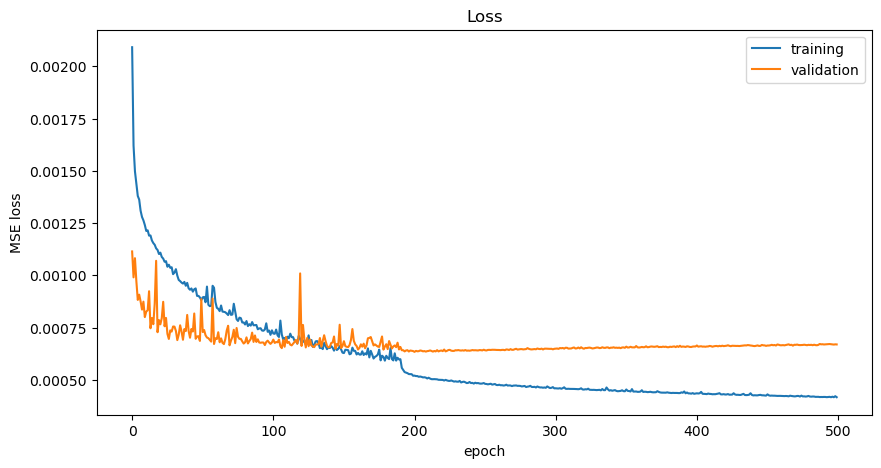

In [7]:
with open(f'../../../loss/quinn_ResDepth_v12_val_loss.pkl', 'rb') as f:
        val_loss = pickle.load(f)

with open(f'../../../loss/quinn_ResDepth_v12_train_loss.pkl', 'rb') as f:
        train_loss = pickle.load(f)


# plot loss over all epochs
f, ax = plt.subplots(figsize=(10,5))
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.set_title('Loss')
ax.legend()

# save figure
plt.savefig(f'../../../figs/quinn_ResDepth_v12_loss.png', dpi=300)

In [8]:
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

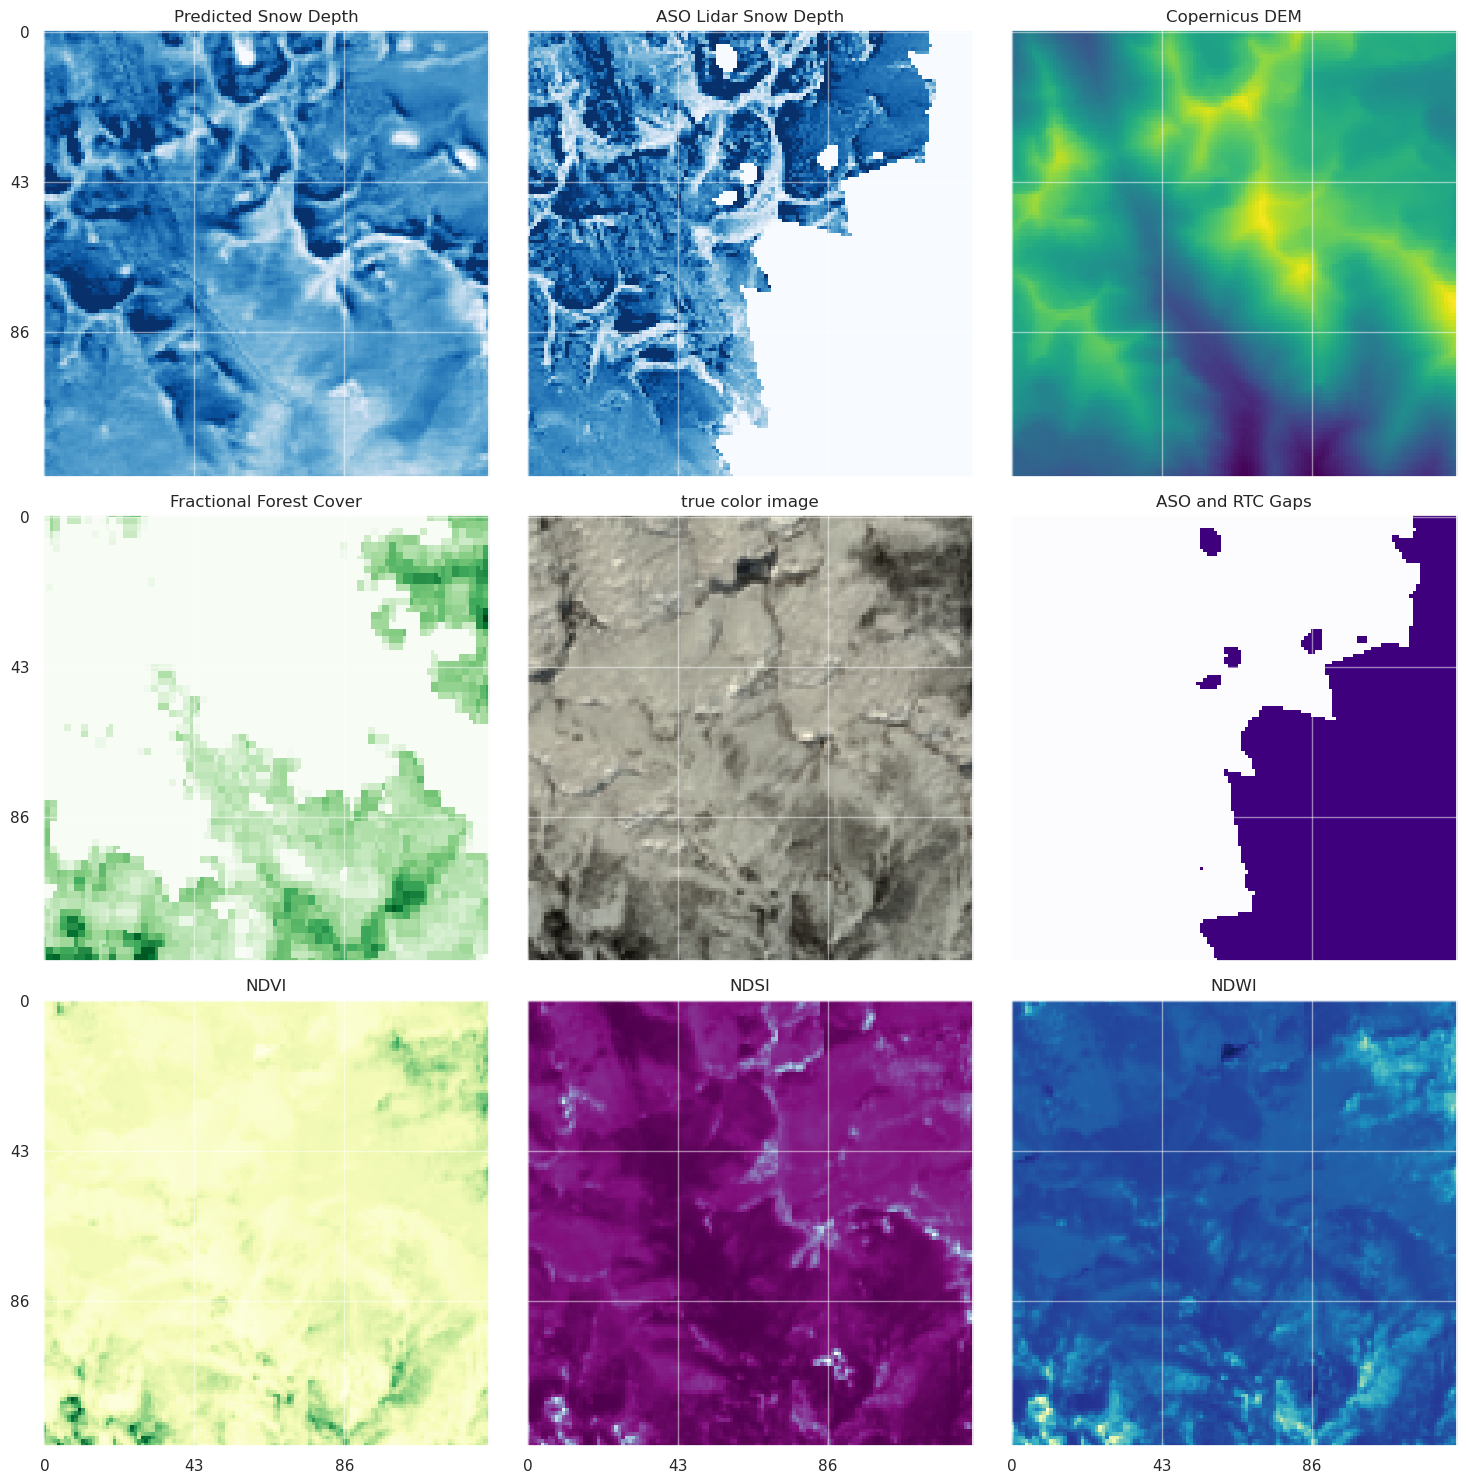

In [20]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze() + data_dict['s2_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        f.tight_layout()
    else:
        break

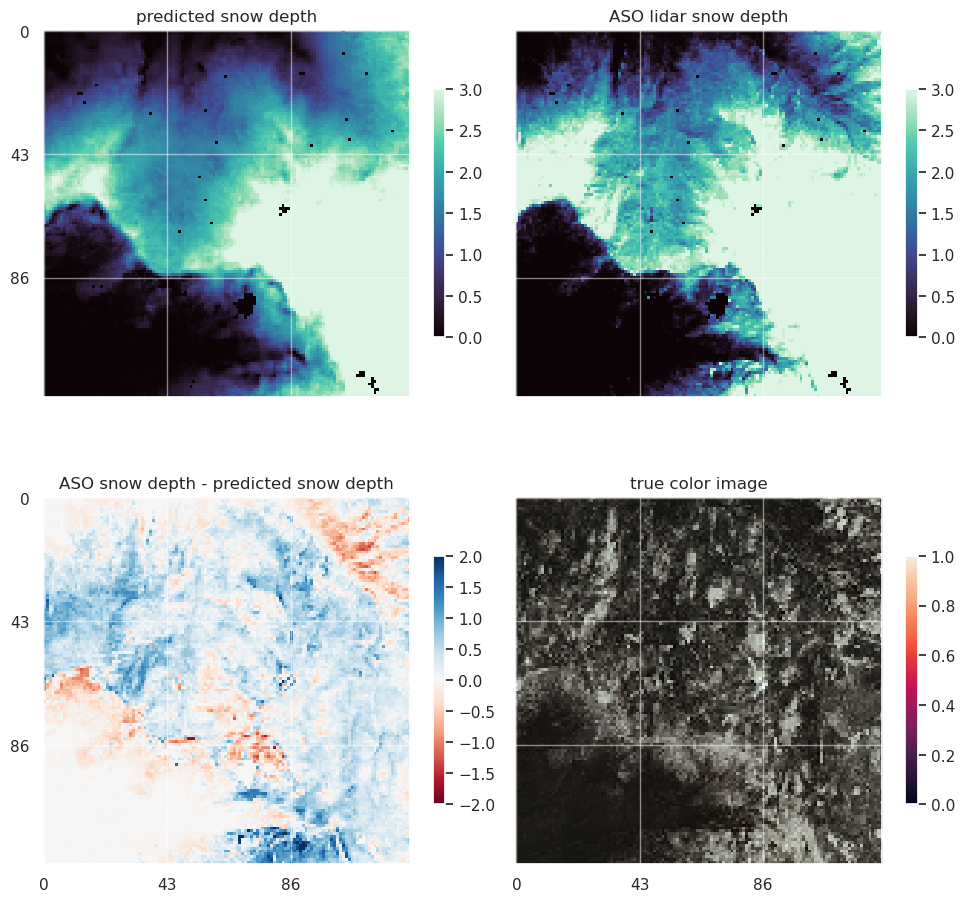

In [107]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = deep_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] + data_dict['s2_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = deep_snow.dataset.undo_norm(pred_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = deep_snow.dataset.undo_norm(aso_sd, deep_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='mako', vmin=0, vmax=3, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='mako', vmin=0, vmax=3, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break